In [2]:
import librosa
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

C:\Users\mikes\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
def get_mfcc(file_path, sample_rate=22050, n_mfcc=13, n_fft=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=sample_rate)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length).T
    mfcc_mean = np.mean(mfcc, axis=0)
    feature_vector = np.array(mfcc_mean)
    return feature_vector

In [4]:
def process_data(dataset_path):
    category_to_num = dict()
    category_to_num["blues"] = 0
    category_to_num["classical"] = 1
    category_to_num["country"] = 2
    category_to_num["disco"] = 3
    category_to_num["hiphop"] = 4
    category_to_num["jazz"] = 5
    category_to_num["metal"] = 6
    category_to_num["pop"] = 7
    category_to_num["reggae"] = 8
    category_to_num["rock"] = 9
    
    X = []
    y = []

    for folder in os.listdir(dataset_path):
        print("Processing: " + folder)  
        for file in os.listdir(dataset_path+ "/" + folder):
            file_path = dataset_path + "/" + folder + "/" + file
            feature_vector = get_mfcc(file_path)
            X.append(feature_vector)
            y.append(category_to_num[folder])
                  
    return np.array(X), np.array(y)    

In [5]:
# process data
audio_dir = "./Data/genres_original"
X, y = process_data(audio_dir)

Processing: blues
Processing: classical
Processing: country
Processing: disco
Processing: hiphop
Processing: jazz
Processing: metal
Processing: pop
Processing: reggae
Processing: rock


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


# normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
import tensorflow.keras as keras

"""
Code for this part of the implementation adapted from: https://www.youtube.com/watch?v=_xcFAiufwd0
Our way is slightly different due to the difference in how we collected the data, 
but this helped with understanding the exact syntax of setting up the model.
"""

model = keras.Sequential([

    # input layer
    keras.layers.Input(shape=(X_train.shape[1],)),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu'),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu'),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu'),

    # output layer
    keras.layers.Dense(10, activation='softmax')
])
    
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10, epochs=50)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               7168      
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 155,594
Trainable params: 155,594
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
70/70 [==============================] - 1s 7ms/step - loss: 2.1932 - accuracy: 0.2389 - val_loss: 2.0669 - val_accuracy: 0.3600
Epoch 2/50
70/70 [======================

In [24]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_classes)

10/10 [==============================] - 0s 2ms/step


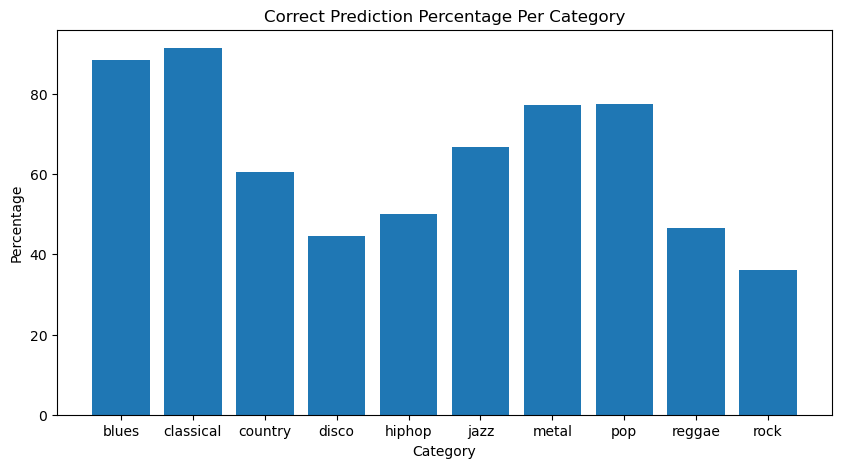

In [25]:
import matplotlib.pyplot as plt
correct_per_category = np.diag(conf_matrix)
total_per_category = np.sum(conf_matrix, axis=1)
correct_percentage_per_category = 100 * correct_per_category / total_per_category
plt.figure(figsize=(10,5))
plt.bar(categories, correct_percentage_per_category)
plt.title('Correct Prediction Percentage Per Category')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.show()

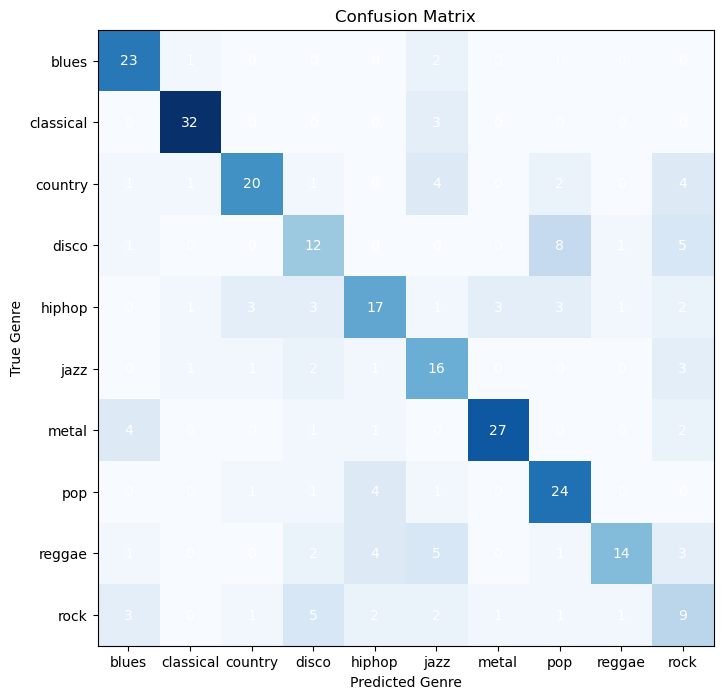

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(conf_matrix, cmap='Blues')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Genre')
ax.set_ylabel('True Genre')
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories)
ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)
ax.grid(False)
for i in range(len(categories)):
    for j in range(len(categories)):
        ax.text(j, i, str(conf_matrix[i][j]), ha='center', va='center', color='white')
plt.show()